In [1]:
from __future__ import print_function, division
import numpy as np

## 1. Data loading

In [2]:
import cPickle as pickle
import gzip

In [3]:
class Data(object):
    def __init__(self, data):
        self._x, self._y = data
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._num_examples = self._x.shape[0]
        self._cur_perm = np.arange(self._num_examples)

    @property
    def epochs_completed(self):
        return self._epochs_completed
    
    @property
    def data(self):
        return self._x, self._y
    
    @property
    def num_examples(self):
        return self._num_examples
    
    def next_batch(self, batch_size):
        """Return the next batch_size examples from the data"""
        # shuffle at the beginning of each epoch
        if self._index_in_epoch == 0:
            np.random.shuffle(self._cur_perm)
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        end = self._index_in_epoch
        
        # indices of next batch (might be smaller than batch_size)
        batch_idx = self._cur_perm[start:end]
        
        # after each epoch
        if self._index_in_epoch >= self._num_examples:
            self._epochs_completed += 1
            # reset the index
            self._index_in_epoch = 0
            
        return self._x[batch_idx], self._y[batch_idx]
    
    def reset(self):
        """Reset num of epochs and index in epoch"""
        self._index_in_epoch = 0
        self._epochs_completed = 0

In [4]:
# Load the dataset (from http://deeplearning.net/tutorial/gettingstarted.html)
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f)

In [5]:
tr = Data(train_set)
va = Data(valid_set)
te = Data(test_set)

In [6]:
print("training size:\t\t{0:,}".format(tr.num_examples))
print("validation size:\t{0:,}".format(va.num_examples))
print("testing size:\t\t{0:,}".format(te.num_examples))

training size:		50,000
validation size:	10,000
testing size:		10,000


## 2. Visualize the digits

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
# randomly select 16 images from training and visualize
# each image is represented as a 784 vector flattened from 28x28 pixels (row major)
sample_images = np.zeros((28*4, 28*4))
sample_x, sample_y = tr.next_batch(16)
tr.reset()
# columns of 4 digits
for i in xrange(4):
    sample_images[:, 28*i:28*(i+1)] = sample_x[4*i:4*(i+1)].reshape((4*28, 28))

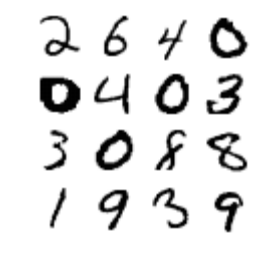

True labels:
[[2 6 4 0]
 [0 4 0 3]
 [3 0 8 8]
 [1 9 3 9]]


In [9]:
fig = plt.imshow(sample_images)
fig.set_cmap('Greys')
plt.axis('off')
plt.show()
print("True labels:")
print(sample_y.reshape((4, 4)).transpose())

## 3. Example: Softmax regression

In [10]:
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer

**Input layer**

$$x\in \mathbb{R}^{d}, y\in \mathbb{R}^{l}$$

$d:$ feature dimension; $l:$ number of classes

In [54]:
# placeholders to feed input data
# x: input images flattened
# y: true labels
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])

**Linear layer**
$$W\in \mathbb{R}^{d\times l}, b\in \mathbb{R}^{l}$$

$$a = Wx+b$$

In [55]:
# variables to learn
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

**Softmax layer**

$$\hat{y}=softmax(a)$$

In [56]:
# softmax layer: make predictions
y_hat = tf.nn.softmax(tf.matmul(x, W) + b)

In [57]:
# define loss function
cross_entropy = -tf.reduce_sum(y*tf.log(y_hat))

In [58]:
# SGD with fixed step size
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)

In [59]:
# initialize all variables
init = tf.initialize_all_variables()

In [60]:
# start a session and run the experiment
sess = tf.Session()
sess.run(init)

In [61]:
# binarizer to transform labels to 10 dimensional binary vectors
binarizer = LabelBinarizer().fit(np.arange(10))

In [71]:
# 1000 iterations (not epochs) with batch size 100
# number of epochs = 1000 * 100 / 50000 = 2
tr.reset()
for i in range(1000):
    batch_xs, batch_ys = tr.next_batch(100)
    sess.run(train_step, 
             feed_dict={x: batch_xs, y: binarizer.transform(batch_ys)})

In [72]:
# calculate prediction accuracy
correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [74]:
# test on validation set
va_x, va_y = va.data

In [75]:
print(sess.run(accuracy, feed_dict={x: va_x, y: binarizer.transform(va_y)}))

0.9244
